```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# {index}`Cake Eating IV: Time Iteration <single: Cake Eating IV: Time Iteration>`

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

## Overview

In this lecture, we introduce the core idea of **time iteration**: iterating on
a guess of the optimal policy using the Euler equation.

This approach differs from the value function iteration we used in
{doc}`cake_eating_stochastic`, where we iterated on the value function itself.

Time iteration exploits the structure of the Euler equation to find the optimal
policy directly, rather than computing the value function as an intermediate step.

The key advantage is computational efficiency: by working directly with the
policy function, we can often solve problems faster than with value function iteration.

However, time iteration is not the most efficient Euler equation-based method
available.

In {doc}`cake_eating_egm`, we'll introduce the **endogenous
grid method** (EGM), which provides an even more efficient way to solve the
problem.

For now, our goal is to understand the basic mechanics of time iteration and
how it leverages the Euler equation.

Let's start with some imports:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import brentq
from typing import NamedTuple, Callable

## The Euler Equation

Our first step is to derive the Euler equation, which is a generalization of
the Euler equation we obtained in {doc}`cake_eating`.

We take the model set out in {doc}`cake_eating_stochastic` and add the following assumptions:

1. $u$ and $f$ are continuously differentiable and strictly concave
1. $f(0) = 0$
1. $\lim_{c \to 0} u'(c) = \infty$ and $\lim_{c \to \infty} u'(c) = 0$
1. $\lim_{k \to 0} f'(k) = \infty$ and $\lim_{k \to \infty} f'(k) = 0$

The last two conditions are usually called **Inada conditions**.

Recall the Bellman equation

```{math}
:label: cpi_fpb30

v^*(x) = \max_{0 \leq c \leq x}
    \left\{
        u(c) + \beta \int v^*(f(x - c) z) \phi(dz)
    \right\}
\quad \text{for all} \quad
x \in \mathbb R_+
```

Let the optimal consumption policy be denoted by $\sigma^*$.

We know that $\sigma^*$ is a $v^*$-greedy policy so that $\sigma^*(x)$ is the maximizer in {eq}`cpi_fpb30`.

The conditions above imply that

* $\sigma^*$ is the unique optimal policy for the stochastic cake eating problem
* the optimal policy is continuous, strictly increasing and also **interior**, in the sense that $0 < \sigma^*(x) < x$ for all strictly positive $x$, and
* the value function is strictly concave and continuously differentiable, with

```{math}
:label: cpi_env

(v^*)'(x) = u' (\sigma^*(x) ) := (u' \circ \sigma^*)(x)
```

The last result is called the **envelope condition** due to its relationship with the [envelope theorem](https://en.wikipedia.org/wiki/Envelope_theorem).

To see why {eq}`cpi_env` holds, write the Bellman equation in the equivalent
form

$$
v^*(x) = \max_{0 \leq k \leq x}
    \left\{
        u(x-k) + \beta \int v^*(f(k) z) \phi(dz)
    \right\},
$$

Differentiating with respect to $x$, and then evaluating at the optimum yields {eq}`cpi_env`.

(Section 12.1 of [EDTC](https://johnstachurski.net/edtc.html) contains full proofs of these results, and closely related discussions can be found in many other texts.)

Differentiability of the value function and interiority of the optimal policy
imply that optimal consumption satisfies the first-order condition associated
with {eq}`cpi_fpb30`, which is

```{math}
:label: cpi_foc

u'(\sigma^*(x)) = \beta \int (v^*)'(f(x - \sigma^*(x)) z) f'(x - \sigma^*(x)) z \phi(dz)
```

Combining {eq}`cpi_env` and the first-order condition {eq}`cpi_foc` gives the **Euler equation**

```{math}
:label: cpi_euler

(u'\circ \sigma^*)(x)
= \beta \int (u'\circ \sigma^*)(f(x - \sigma^*(x)) z) f'(x - \sigma^*(x)) z \phi(dz)
```

We can think of the Euler equation as a functional equation

```{math}
:label: cpi_euler_func

(u'\circ \sigma)(x)
= \beta \int (u'\circ \sigma)(f(x - \sigma(x)) z) f'(x - \sigma(x)) z \phi(dz)
```

over interior consumption policies $\sigma$, one solution of which is the optimal policy $\sigma^*$.

Our aim is to solve the functional equation {eq}`cpi_euler_func` and hence obtain $\sigma^*$.

### The Coleman-Reffett Operator

Recall the Bellman operator

```{math}
:label: fcbell20_coleman

Tv(x) := \max_{0 \leq c \leq x}
\left\{
    u(c) + \beta \int v(f(x - c) z) \phi(dz)
\right\}
```

Just as we introduced the Bellman operator to solve the Bellman equation, we
will now introduce an operator over policies to help us solve the Euler
equation.

This operator $K$ will act on the set of all $\sigma \in \Sigma$
that are continuous, strictly increasing and interior.

Henceforth we denote this set of policies by $\mathscr P$

1. The operator $K$ takes as its argument a $\sigma \in \mathscr P$ and
1. returns a new function $K\sigma$, where $K\sigma(x)$ is the $c \in (0, x)$ that solves

```{math}
:label: cpi_coledef

u'(c)
= \beta \int (u' \circ \sigma) (f(x - c) z ) f'(x - c) z \phi(dz)
```

We call this operator the **Coleman-Reffett operator** to acknowledge the work of
{cite}`Coleman1990` and {cite}`Reffett1996`.

In essence, $K\sigma$ is the consumption policy that the Euler equation tells
you to choose today when your future consumption policy is $\sigma$.

The important thing to note about $K$ is that, by
construction, its fixed points coincide with solutions to the functional
equation {eq}`cpi_euler_func`.

In particular, the optimal policy $\sigma^*$ is a fixed point.

Indeed, for fixed $x$, the value $K\sigma^*(x)$ is the $c$ that
solves

$$
u'(c)
= \beta \int (u' \circ \sigma^*) (f(x - c) z ) f'(x - c) z \phi(dz)
$$

In view of the Euler equation, this is exactly $\sigma^*(x)$.

### Is the Coleman-Reffett Operator Well Defined?

In particular, is there always a unique $c \in (0, x)$ that solves
{eq}`cpi_coledef`?

The answer is yes, under our assumptions.

For any $\sigma \in \mathscr P$, the right side of {eq}`cpi_coledef`

* is continuous and strictly increasing in $c$ on $(0, x)$
* diverges to $+\infty$ as $c \uparrow x$

The left side of {eq}`cpi_coledef`

* is continuous and strictly decreasing in $c$ on $(0, x)$
* diverges to $+\infty$ as $c \downarrow 0$

Sketching these curves and using the information above will convince you that they cross exactly once as $c$ ranges over $(0, x)$.

With a bit more analysis, one can show in addition that $K \sigma \in \mathscr P$
whenever $\sigma \in \mathscr P$.

### Comparison with VFI (Theory)

It is possible to prove that there is a tight relationship between iterates of
$K$ and iterates of the Bellman operator.

Mathematically, $T$ and $K$ are **topologically conjugate** under a translation
that involves differentiation in one direction and integration in the other.

This conjugacy implies that if iterates of one operator converge then
so do iterates of the other, and vice versa.

Moreover, there is a sense in which they converge *at the same rate*, at least in theory.

However, it turns out that the operator $K$ is more stable *numerically*
and hence more efficient in the applications we consider.

This is because

* $K$ exploits additional structure because it uses first-order conditions, and
* policies near the optimal policy have less curvature and hence are easier to
  approximate than value functions near the optimal value function.

Examples are given below.


## Implementation

Let's turn to implementation.

```{note}
In this lecture we mainly focus on the algorithm, favoring clarity over efficiency in the code.

In later lectures we will optimize both the algorithm and the code.
```



As in {doc}`cake_eating_stochastic`, we assume that

* $u(c) = \ln c$
* $f(x-c) = (x-c)^{\alpha}$
* $\phi$ is the distribution of $\xi := \exp(\mu + \nu \zeta)$ when $\zeta$ is standard normal

This allows us to compare our results to the analytical solutions we obtained in
that lecture:

In [3]:
def v_star(x, α, β, μ):
    """
    True value function
    """
    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * np.log(x)

def σ_star(x, α, β):
    """
    True optimal policy
    """
    return (1 - α * β) * x

As discussed above, our plan is to solve the model using time iteration, which
means iterating with the operator $K$.

For this we need access to the functions $u'$ and $f, f'$.

We use the same `Model` structure from {doc}`cake_eating_stochastic`.

In [4]:
class Model(NamedTuple):
    u: Callable        # utility function
    f: Callable        # production function
    β: float           # discount factor
    μ: float           # shock location parameter
    ν: float           # shock scale parameter
    grid: np.ndarray   # state grid
    shocks: np.ndarray # shock draws
    α: float = 0.4     # production function parameter
    u_prime: Callable = None        # derivative of utility
    f_prime: Callable = None        # derivative of production


def create_model(
        u: Callable,
        f: Callable,
        β: float = 0.96,
        μ: float = 0.0,
        ν: float = 0.1,
        grid_max: float = 4.0,
        grid_size: int = 120,
        shock_size: int = 250,
        seed: int = 1234,
        α: float = 0.4,
        u_prime: Callable = None,
        f_prime: Callable = None
    ) -> Model:
    """
    Creates an instance of the cake eating model.
    """
    # Set up grid
    grid = np.linspace(1e-4, grid_max, grid_size)

    # Store shocks (with a seed, so results are reproducible)
    np.random.seed(seed)
    shocks = np.exp(μ + ν * np.random.randn(shock_size))

    return Model(u, f, β, μ, ν, grid, shocks, α, u_prime, f_prime)

Now we implement a method called `euler_diff`, which returns

```{math}
:label: euler_diff

u'(c) - \beta \int (u' \circ \sigma) (f(x - c) z ) f'(x - c) z \phi(dz)
```

In [5]:
def euler_diff(c: float, σ: np.ndarray, x: float, model: Model) -> float:
    """
    Set up a function such that the root with respect to c,
    given x and σ, is equal to Kσ(x).

    """

    # Unpack
    u, f, β, μ, ν, grid, shocks, α, u_prime, f_prime = model

    # Turn σ into a function via interpolation
    σ_func = lambda x: np.interp(x, grid, σ)

    # Now set up the function we need to find the root of.
    vals = u_prime(σ_func(f(x - c, α) * shocks)) * f_prime(x - c, α) * shocks
    return u_prime(c) - β * np.mean(vals)

The function `euler_diff` evaluates integrals by Monte Carlo and
approximates functions using linear interpolation.

We will use a root-finding algorithm to solve {eq}`euler_diff` for $c$ given
state $x$ and $σ$, the current guess of the policy.

Here's the operator $K$, that implements the root-finding step.

In [6]:
def K(σ: np.ndarray, model: Model) -> np.ndarray:
    """
    The Coleman-Reffett operator

    """

    # Unpack
    u, f, β, μ, ν, grid, shocks, α, u_prime, f_prime = model

    σ_new = np.empty_like(σ)
    for i, x in enumerate(grid):
        # Solve for optimal c at x
        c_star = brentq(euler_diff, 1e-10, x-1e-10, args=(σ, x, model))
        σ_new[i] = c_star

    return σ_new

### Testing

Let's generate an instance and plot some iterates of $K$, starting from $σ(x) = x$.

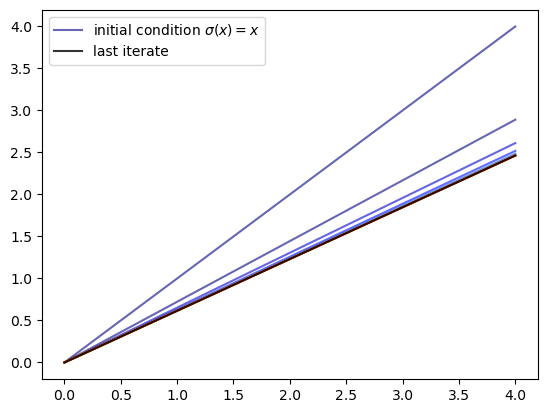

In [7]:
# Define utility and production functions with derivatives
α = 0.4
u = lambda c: np.log(c)
u_prime = lambda c: 1 / c
f = lambda k, α: k**α
f_prime = lambda k, α: α * k**(α - 1)

model = create_model(u=u, f=f, α=α, u_prime=u_prime, f_prime=f_prime)
grid = model.grid

n = 15
σ = grid.copy()  # Set initial condition

fig, ax = plt.subplots()
lb = r'initial condition $\sigma(x) = x$'
ax.plot(grid, σ, color=plt.cm.jet(0), alpha=0.6, label=lb)

for i in range(n):
    σ = K(σ, model)
    ax.plot(grid, σ, color=plt.cm.jet(i / n), alpha=0.6)

# Update one more time and plot the last iterate in black
σ = K(σ, model)
ax.plot(grid, σ, color='k', alpha=0.8, label='last iterate')

ax.legend()

plt.show()

We see that the iteration process converges quickly to a limit
that resembles the solution we obtained in {doc}`cake_eating_stochastic`.

Here is a function called `solve_model_time_iter` that takes an instance of
`Model` and returns an approximation to the optimal policy,
using time iteration.

In [8]:
def solve_model_time_iter(
        model: Model,
        σ_init: np.ndarray,
        tol: float = 1e-5,
        max_iter: int = 1000,
        verbose: bool = True
    ) -> np.ndarray:
    """
    Solve the model using time iteration.

    """
    σ = σ_init
    error = tol + 1
    i = 0

    while error > tol and i < max_iter:
        σ_new = K(σ, model)
        error = np.max(np.abs(σ_new - σ))
        σ = σ_new
        i += 1
        if verbose:
            print(f"Iteration {i}, error = {error}")

    if i == max_iter:
        print("Warning: maximum iterations reached")

    return σ

Let's call it:

In [9]:
# Unpack
grid = model.grid

σ_init = np.copy(grid)
σ = solve_model_time_iter(model, σ_init)

Iteration 1, error = 1.1098265895953756
Iteration 2, error = 0.27827989207957415
Iteration 3, error = 0.09312729948559406
Iteration 4, error = 0.034020038271351805
Iteration 5, error = 0.012820752818722525
Iteration 6, error = 0.004888081560539437
Iteration 7, error = 0.0018718902256105174
Iteration 8, error = 0.0007180512309568066
Iteration 9, error = 0.0002756205293255043
Iteration 10, error = 0.00010582190181418483
Iteration 11, error = 4.063319516811603e-05
Iteration 12, error = 1.560279084289462e-05
Iteration 13, error = 5.991419175455093e-06


Iteration 9, error = 0.0002756205293255043
Iteration 10, error = 0.00010582190181418483
Iteration 11, error = 4.063319516811603e-05
Iteration 12, error = 1.560279084289462e-05
Iteration 13, error = 5.991419175455093e-06


Here is a plot of the resulting policy, compared with the true policy:

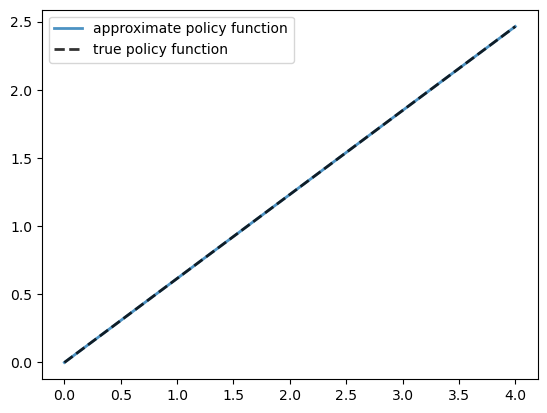

In [10]:
# Unpack
grid, α, β = model.grid, model.α, model.β

fig, ax = plt.subplots()

ax.plot(grid, σ, lw=2,
        alpha=0.8, label='approximate policy function')

ax.plot(grid, σ_star(grid, α, β), 'k--',
        lw=2, alpha=0.8, label='true policy function')

ax.legend()
plt.show()

Again, the fit is excellent.

The maximal absolute deviation between the two policies is

In [11]:
# Unpack
grid, α, β = model.grid, model.α, model.β

np.max(np.abs(σ - σ_star(grid, α, β)))

np.float64(3.7348959489591493e-06)

Time iteration runs faster than value function iteration, as discussed in {doc}`cake_eating_stochastic`.

This is because time iteration exploits differentiability and the first-order conditions, while value function iteration does not use this available structure.

At the same time, there is a variation of time iteration that runs even faster.

This is the endogenous grid method, which we will introduce in {doc}`cake_eating_egm`.

## Exercises

```{exercise}
:label: cpi_ex1

Solve the stochastic cake eating problem with CRRA utility

$$
u(c) = \frac{c^{1 - \gamma}} {1 - \gamma}
$$

Set `γ = 1.5`.

Compute and plot the optimal policy.
```

```{solution-start} cpi_ex1
:class: dropdown
```

We define the CRRA utility function and its derivative.

In [12]:
γ = 1.5

def u_crra(c):
    return c**(1 - γ) / (1 - γ)

def u_prime_crra(c):
    return c**(-γ)

# Use the same production function as before
model_crra = create_model(u=u_crra, f=f, α=α,
                          u_prime=u_prime_crra, f_prime=f_prime)

Now we solve and plot the policy:

Iteration 1, error = 1.449952719114732
Iteration 2, error = 0.3967698022828947
Iteration 3, error = 0.14845269076775747
Iteration 4, error = 0.06192954031818365
Iteration 5, error = 0.027017665601367424
Iteration 6, error = 0.012019070058330028
Iteration 7, error = 0.005393694573905705
Iteration 8, error = 0.0024299846499917788
Iteration 9, error = 0.0010967197524933692
Iteration 10, error = 0.0004953902833375601
Iteration 11, error = 0.0002238472234141753
Iteration 12, error = 0.0001011641350074921
Iteration 13, error = 4.572272482672446e-05
Iteration 14, error = 2.066580711579391e-05
Iteration 15, error = 9.340704450133686e-06
CPU times: user 691 ms, sys: 3.05 ms, total: 694 ms
Wall time: 693 ms


Iteration 7, error = 0.005393694573905705
Iteration 8, error = 0.0024299846499917788
Iteration 9, error = 0.0010967197524933692
Iteration 10, error = 0.0004953902833375601
Iteration 11, error = 0.0002238472234141753
Iteration 12, error = 0.0001011641350074921


Iteration 13, error = 4.572272482672446e-05
Iteration 14, error = 2.066580711579391e-05
Iteration 15, error = 9.340704450133686e-06


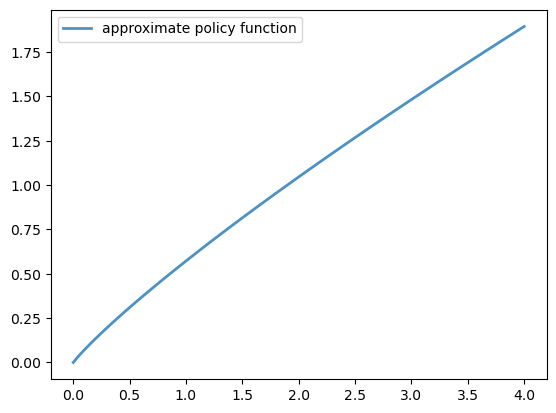

CPU times: user 691 ms, sys: 3.05 ms, total: 694 ms
Wall time: 693 ms


In [13]:
%%time
# Unpack
grid = model_crra.grid

σ_init = np.copy(grid)
σ = solve_model_time_iter(model_crra, σ_init)


fig, ax = plt.subplots()

ax.plot(grid, σ, lw=2,
        alpha=0.8, label='approximate policy function')

ax.legend()
plt.show()

```{solution-end}
```